In [2]:
import os

import pandas as pd
import numpy as np
import scipy as sp
import pylab as plt
import regex as re

from dataclasses import dataclass
from pathlib import Path
from typing import List

In [3]:
base_path = Path(os.getcwd())
csv_files = [fpath for fpath in (base_path / '777 Documents').glob('*.csv')]

rename_dict = {'טיפוס דירה (תשריט) ': 'apt_type',
              'מספר דירה': 'apt_number',
              'מספר מגרש בתב"ע': 'parcel_taba_number',
              'מספר/שם מבנה': 'building_number',
              'מספר חדרים': 'number_of_rooms',
              'שטח דירה (מטר)': 'apt_area',
              'קומה': 'apt_floor',
              'מספר מחסן': 'shed_number',
              'שטח מחסן': 'shed_area',
              'שטח מרפסת שמש ו/או שטח גינה צמודה': 'garden_or_patio_area',
              'מחירון נכון ליום 15.2.22': 'price',
              'כיוונים': 'directions',
              'מספרי חניות': 'parking1',               
              'מספרי חניות.1': 'parking2'}

In [4]:
data = [pd.read_csv(fpath).rename(columns=rename_dict) for fpath in csv_files]
data = pd.concat(data, ignore_index=True)

num_apts = data.shape[0]

In [5]:
@dataclass
class Apartment(object):
    price: float
    type: str
    number: int
    building: str
    building_number: int
    floor: int
    num_rooms: float
    area: float
    floor: int
    shed_number: int
    shed_area: float
    patio_area: float
    directions: str
    parcel_taba: int
    num_parking_spots: int
    parking1_number: int
    parking2_number: int
    
    @staticmethod
    def from_df(df: pd.DataFrame):
        parking1 = df['parking1']
        parking2 = df['parking2']
        
        num_parking_spots = 1
        if not np.isnan(parking2):
            num_parking_spots = 2
        
        price = float(df['price'].replace('.',''))
        
        building_number = np.nan
        
        return Apartment(price=price,
                        type=df['apt_type'],
                        number=df['apt_number'],
                        floor=int(df['apt_floor']),
                        building=df['building_number'],
                        building_number=building_number,
                        num_rooms=df['number_of_rooms'],
                        area=df['apt_area'],
                        shed_number=df['shed_number'],
                        shed_area=df['shed_area'],
                        patio_area=df['garden_or_patio_area'],
                        directions=df['directions'],
                        parcel_taba=df['parcel_taba_number'],
                        num_parking_spots=num_parking_spots,
                        parking1_number=df['parking1'],
                        parking2_number=df['parking2'])
    

def apt_price_calc(base_price, apt: Apartment):        
    allowed_areas = {2: 70, 3: 90, 4: 110, 5: 125, 6: 140}
    num_rooms = apt.num_rooms
    num_whole_rooms = int(np.floor(apt.num_rooms))
    num_half_rooms = 2*(num_rooms - num_whole_rooms)
    
    base_allowed_area = allowed_areas[num_whole_rooms] + 9*num_half_rooms

    if apt.area <= base_allowed_area:
        primary = apt.area*base_price
    else:
        primary = (apt.area - base_allowed_area)*0.85*base_price + base_allowed_area*base_price
    
    parking = 3*base_price*apt.num_parking_spots 
    patio = 0.3*base_price*apt.patio_area 
    shed = 0.4*base_price*apt.shed_area
    
    floor_correction = 1
    
    if apt.floor == 1:
        floor_correction = 0.97
    elif apt.floor == 2:
        floor_correction = 0.98
    elif apt.floor == 3:
        floor_correction = 0.99
    elif apt.floor >= 7:
        pct_increase = apt.floor - 6
        floor_correction = 1 + pct_increase/100
    
    price = floor_correction*(primary + parking + patio + shed)
    
    return price

In [6]:
all_apts = []
base_price_777 = 16328.52

for idx, row in data.iterrows():
    all_apts.append(Apartment.from_df(row))

In [7]:
N = 31

print(f'Apt #{all_apts[N].number}, floor: {all_apts[N].floor}, Price: {all_apts[N].price}, Rooms: {all_apts[N].num_rooms}')
apt_price_calc(base_price_777,all_apts[N])

Apt #33, floor: 7, Price: 1480019.0, Rooms: 3.0


1388197.70271

Mean ratio: 6.610000000000027%, Max ratio: 6.610000000000005%, Min ratio: 6.610000000000005%


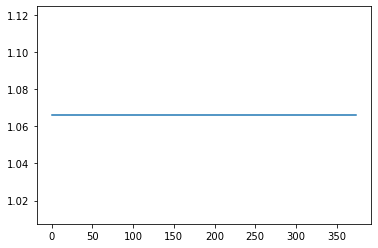

In [8]:
p_increase = lambda n: all_apts[n].price/apt_price_calc(base_price_777, all_apts[n])


expected_prices = np.zeros((num_apts,))
listed_prices = np.zeros((num_apts,))

for idx, apt in enumerate(all_apts):
    expected_prices[idx] = apt_price_calc(base_price_777, apt)
    listed_prices[idx] = apt.price
    
ratios = np.round(listed_prices / expected_prices, decimals=4)

print(f'Mean ratio: {(np.mean(ratios) - 1)*100}%, Max ratio: {(np.max(ratios) - 1)*100}%, Min ratio: {(np.min(ratios) - 1)*100}%')

for N in np.where(ratios == 1.063)[0].tolist():
    apt = all_apts[N]
    print(f'Apt #{apt.number}, floor: {apt.floor}, Price: {apt.price}, Rooms: {apt.num_rooms}, Area: {apt.area}')


plt.figure()
plt.plot(ratios)

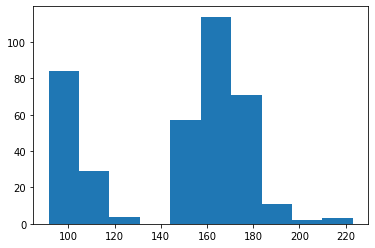

In [9]:
cost_of_index = np.zeros(ratios.shape)

for idx, apt in enumerate(all_apts):
    cost_of_index[idx] = apt.price*(ratios[0] - 1)/1000
    
hist = plt.hist(cost_of_index)

In [10]:
apt_price_calc(base_price_777, all_apts[0])

2830157.05752

In [11]:
def shed_multiplicity(apt_list: List[Apartment], building_complex: int):
    sheds_taken = {}
    sheds_multiple = []
    for apt in apt_list:
        if apt.parcel_taba == building_complex:
            if apt.shed_number in sheds_taken:
                sheds_taken[apt.shed_number].append(apt.number)
            else:
                sheds_taken[apt.shed_number] = [apt.number]
    
    return sheds_taken, sheds_multiple

taken, mult = shed_multiplicity(all_apts, building_complex=101)

In [12]:
[apt for apt in all_apts if apt.shed_number == 18 and apt.parcel_taba == 101]

[Apartment(price=2829089.0, type=nan, number=76, building='בנין 1', building_number=nan, floor=15, num_rooms=6.0, area=138.66, shed_number=18, shed_area=7.94, patio_area=14.19, directions='מע-דרום', parcel_taba=101, num_parking_spots=1, parking1_number=138, parking2_number=nan),
 Apartment(price=2660463.0, type='D', number=31, building='בנין 2', building_number=nan, floor=6, num_rooms=6.0, area=138.66, shed_number=18, shed_area=9.77, patio_area=14.19, directions='מע-דר', parcel_taba=101, num_parking_spots=2, parking1_number=49, parking2_number=50.0),
 Apartment(price=2795463.0, type='D', number=71, building='בנין 3', building_number=nan, floor=14, num_rooms=6.0, area=138.66, shed_number=18, shed_area=6.92, patio_area=14.19, directions='מע-דרום', parcel_taba=101, num_parking_spots=1, parking1_number=182, parking2_number=nan)]

In [13]:
# re.search(all_apts[0].building
re.search(

SyntaxError: unexpected EOF while parsing (1243778209.py, line 2)